#Project Setup - Fraud Detection Training Pipeline

This project is developed on Ubuntu via Windows Subsystem for Linux (WSL) and uses the following technologies:

- Apache Spark 3.5.5

- Scala 2.12.18

- Apache Kafka 4.0.0

- Apache Airflow 3.0.0

- SendGrid for sending fraud alert emails

#1. Model Training

File: **train_model.py**

Setup environment

In [ ]:
# Create and activate Python virtual environment
python3 -m venv ~/venvs/fraud-env
source ~/venvs/fraud-env/bin/activate

# Upgrade pip and install dependencies
pip install --upgrade pip
pip install faker pyspark numpy
pip install kafka-python sendgrid python-dotenv

Run model training script

In [ ]:
# Navigate to project directory
cd "/mnt/d/PATH_TO_PROJECT_DIRECTORY"

# Run Spark job to train model
spark-submit src/train_model.py

After running, a models/ folder will be created with your trained model.

#2. Streaming Pipeline Setup

##Terminal 1 – Start Zookeeper & Kafka Broker

In [ ]:
source ~/venvs/fraud-env/bin/activate

# Start Zookeeper
cd /mnt/c/PATH_TO_zookeeper
bin/zkServer.sh start

In [ ]:
# (Optional) Download and extract Kafka 4.0.0 if not already done
cd ~
wget https://downloads.apache.org/kafka/4.0.0/kafka_2.13-4.0.0.tgz
tar -xvzf kafka_2.13-4.0.0.tgz
mv kafka_2.13-4.0.0 kafka

In [ ]:
# Start Kafka broker
cd /mnt/c/PATH_TO_kafka

# (Optional) Stop old Kafka if needed
bin/kafka-server-stop.sh

# Format Kafka log directories
bin/kafka-storage.sh format -t $(bin/kafka-storage.sh random-uuid) -c config/server.properties

# Start Kafka
bin/kafka-server-start.sh config/server.properties

If successful, you'll see logs stating that the Zookeeper and Kafka server has started.

##Terminal 2 – Produce Synthetic Transaction Data

File: **faker_producer.py**

Create Kafka topic **transactions**

In [ ]:
source ~/venvs/fraud-env/bin/activate
cd /mnt/c/PATH_TO_kafka

bash bin/kafka-topics.sh --create \
  --topic transactions \
  --bootstrap-server localhost:9092 \
  --partitions 1 --replication-factor 1

Run the producer script

In [ ]:
cd "/mnt/d/PATH_TO_PROJECT_DIRECTORY"

python src/faker_producer.py

If successful, you'll see **transaction** messages being sent to the Kafka topic.

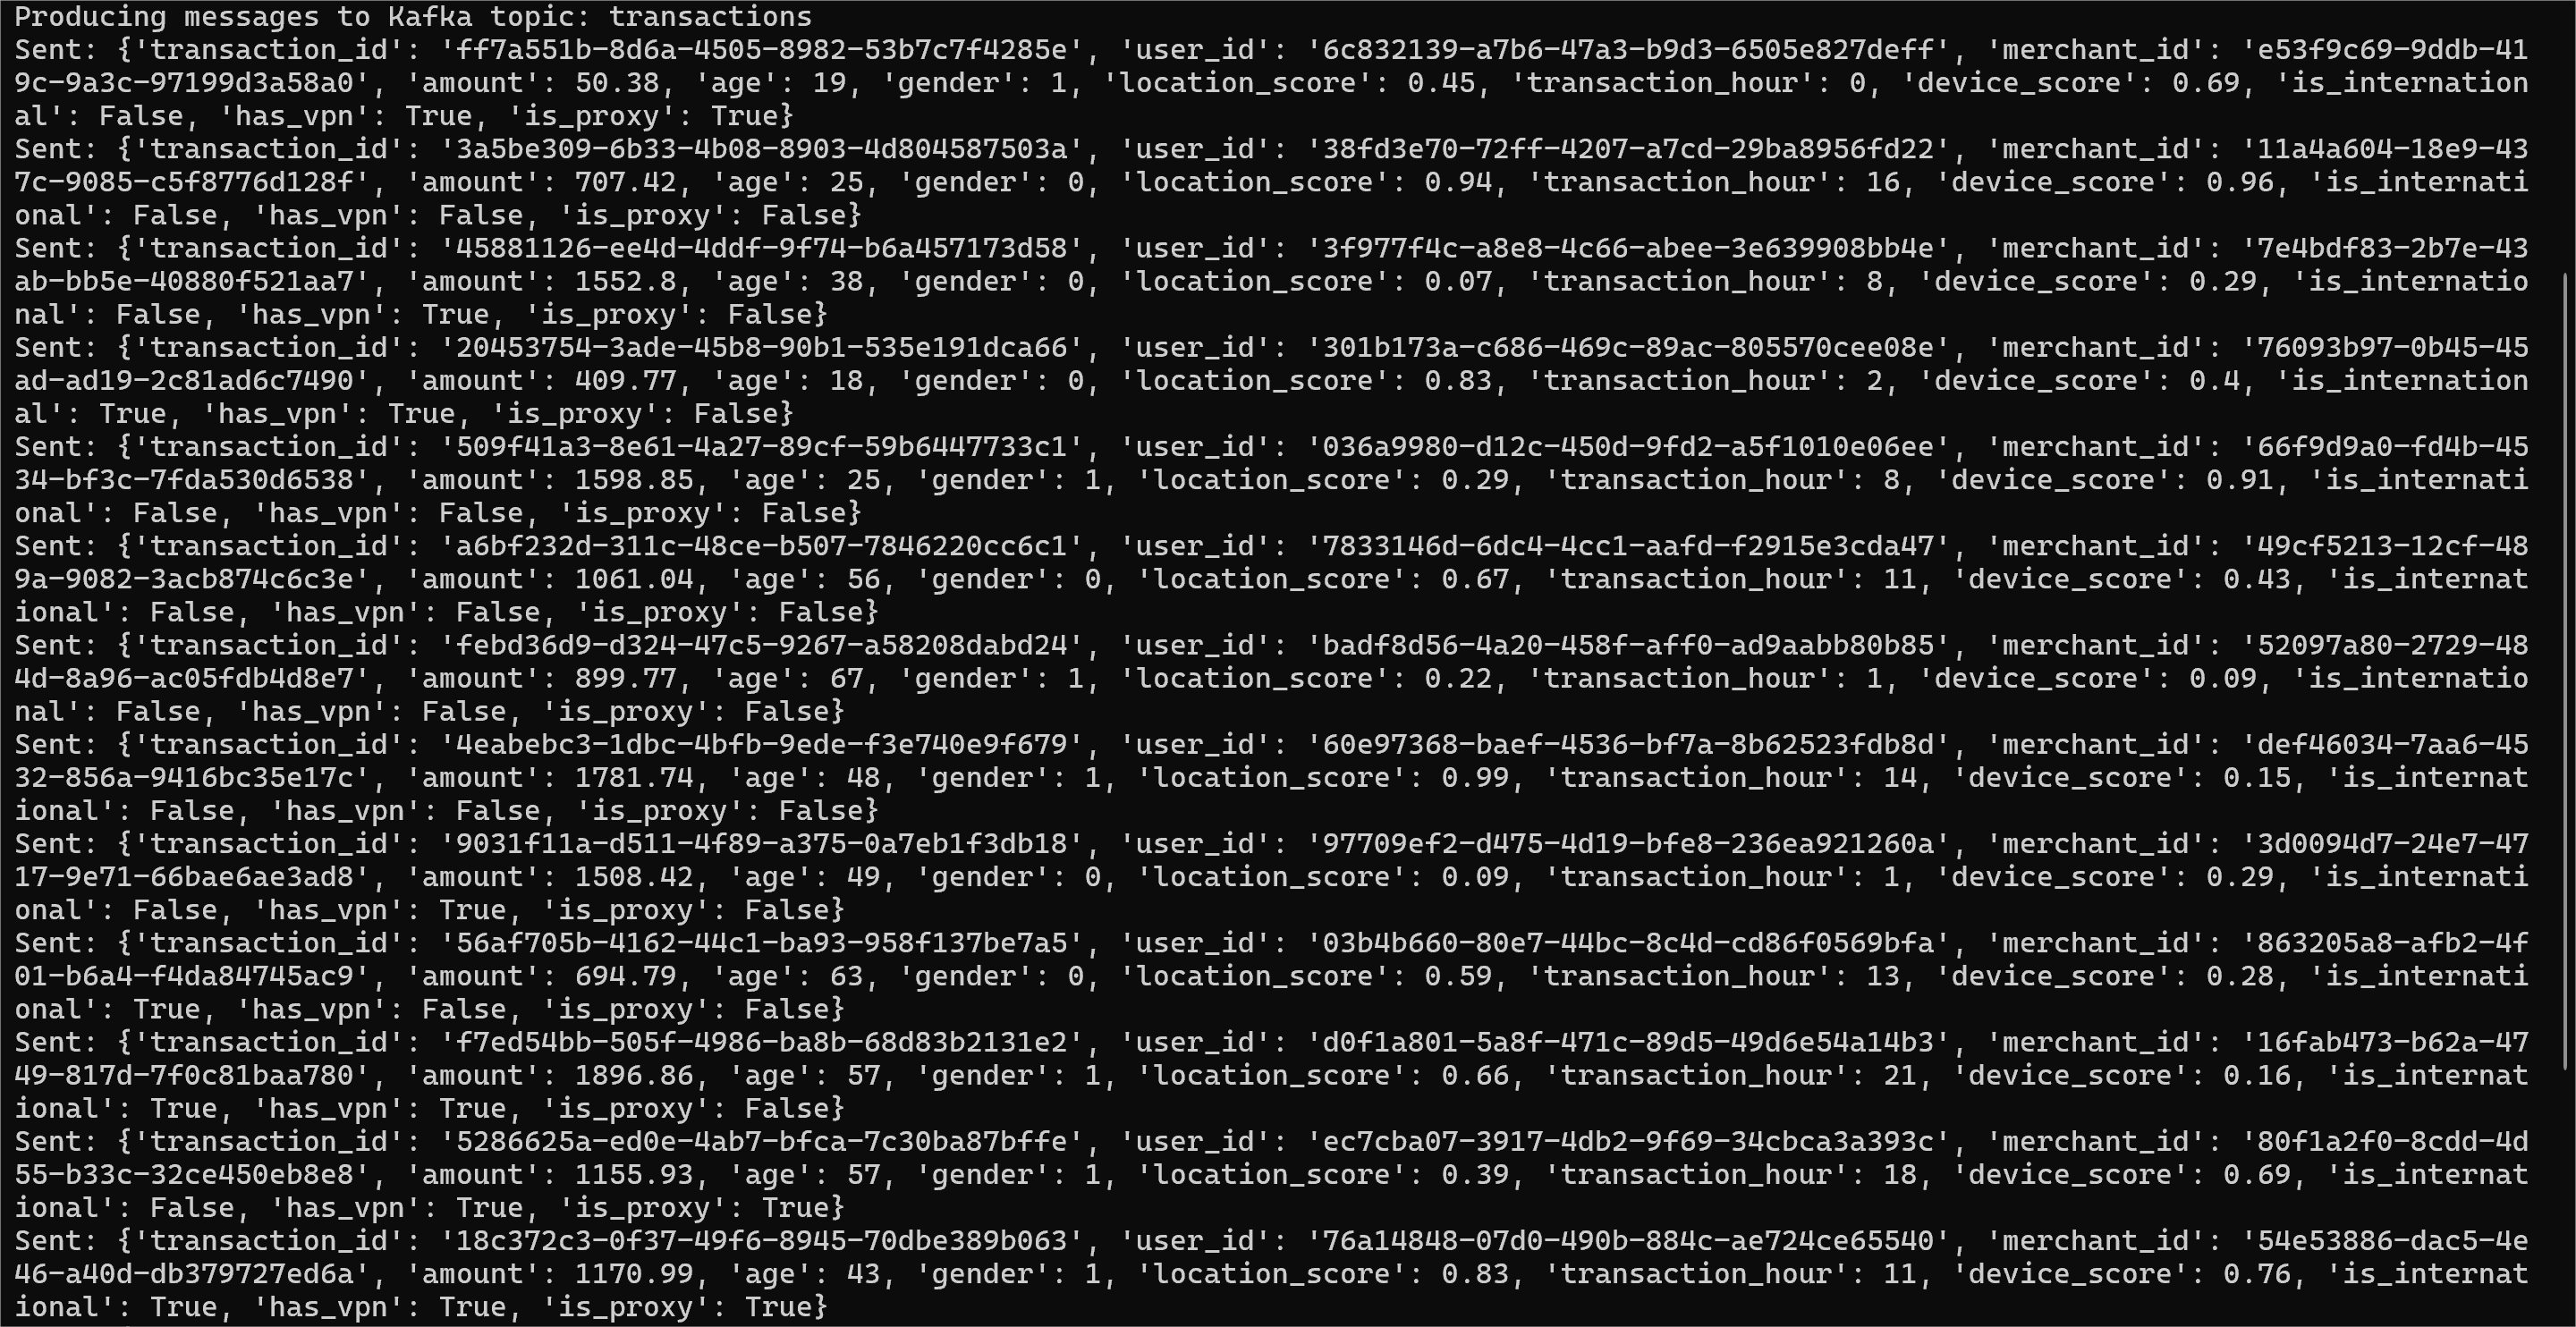

##Terminal 3 – Detect Fraud in Stream

File: **fraud_detection_stream.py**

Create Kafka topic **predictions**

In [ ]:
source ~/venvs/fraud-env/bin/activate
cd /mnt/c/PATH_TO_kafka

bash bin/kafka-topics.sh --create \
  --topic predictions \
  --bootstrap-server localhost:9092 \
  --partitions 1 --replication-factor 1

Run fraud detection streaming job

In [ ]:
cd "/mnt/d/PATH_TO_PROJECT_DIRECTORY"

spark-submit \
  --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,org.apache.kafka:kafka-clients:3.5.0 \
  src/fraud_detection_stream.py

If successful, you'll see predictions being printed or sent to the **predictions** Kafka topic.

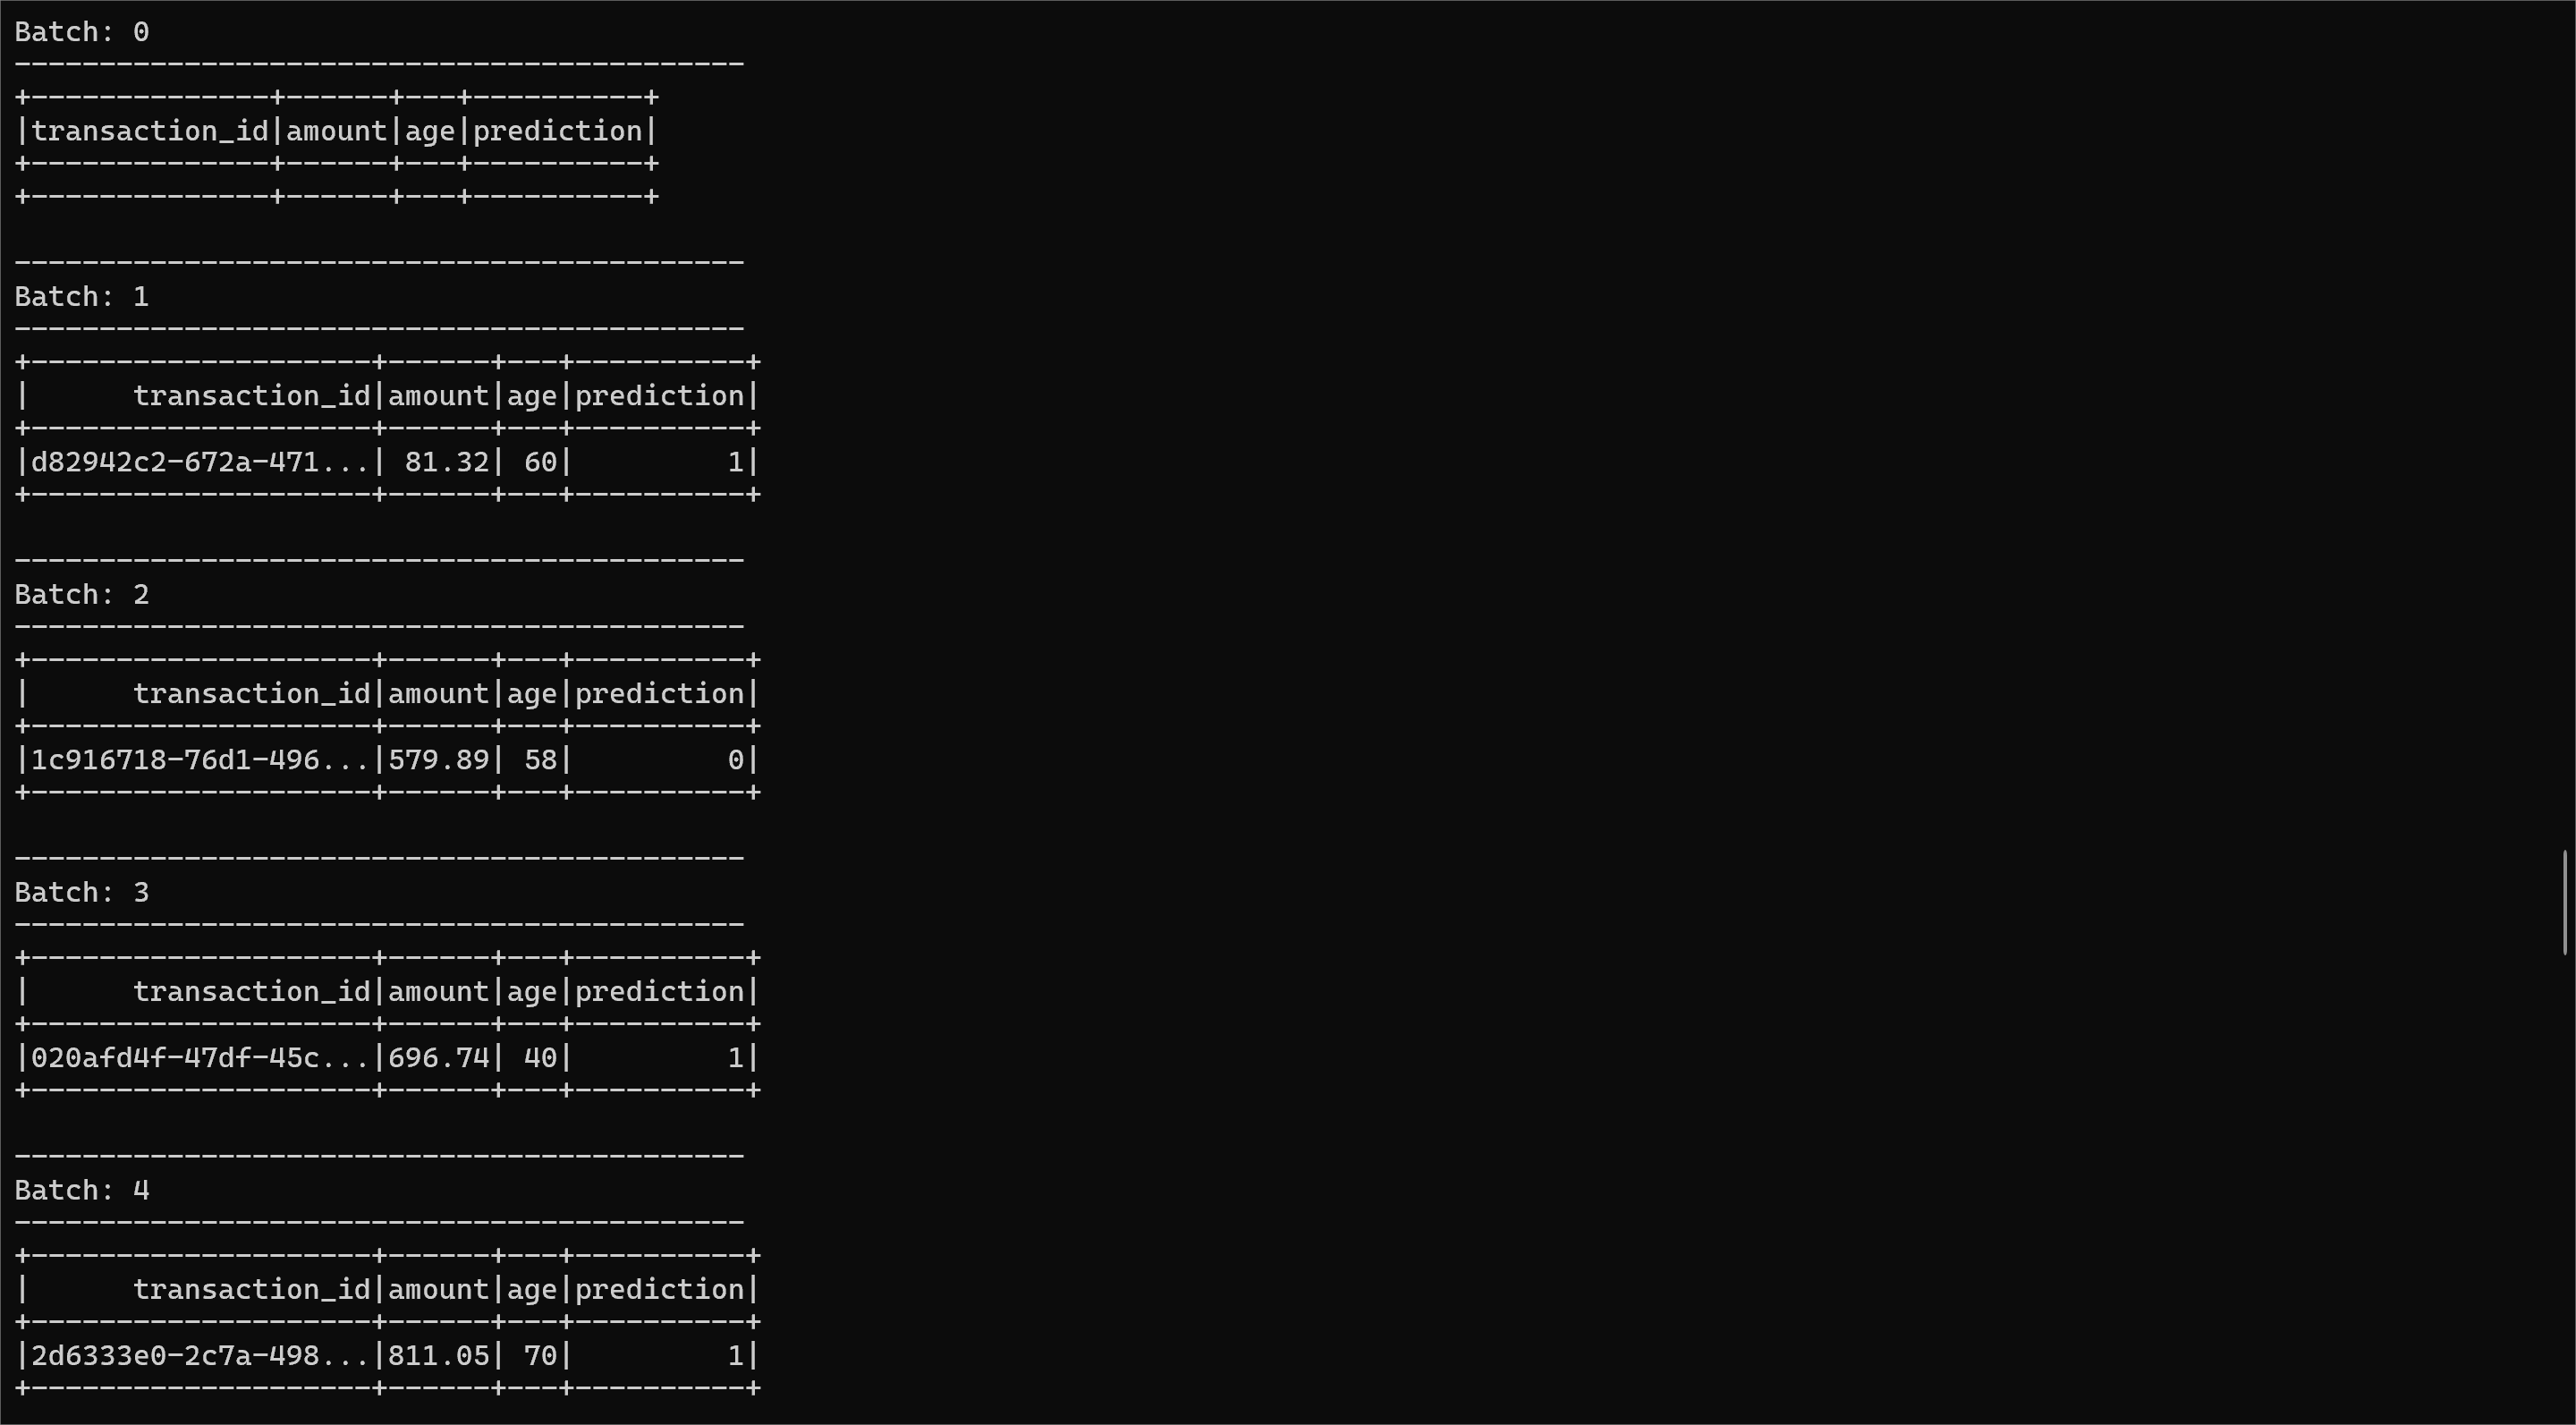

##Terminal 4 – Forward Fraud Alerts to alerts Topic

File: **fraud_alert_producer.py**

Create Kafka topic **alerts**

In [ ]:
source ~/venvs/fraud-env/bin/activate
cd /mnt/c/PATH_TO_kafka

bash bin/kafka-topics.sh --create \
  --topic alerts \
  --bootstrap-server localhost:9092 \
  --partitions 1 --replication-factor 1

Run alert producer script

In [ ]:
cd "/mnt/d/PATH_TO_PROJECT_DIRECTORY"

spark-submit \
  --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,org.apache.kafka:kafka-clients:3.5.0 \
  src/fraud_alert_producer.py

If successful, the alerts will be published to the **alerts** Kafka topic.

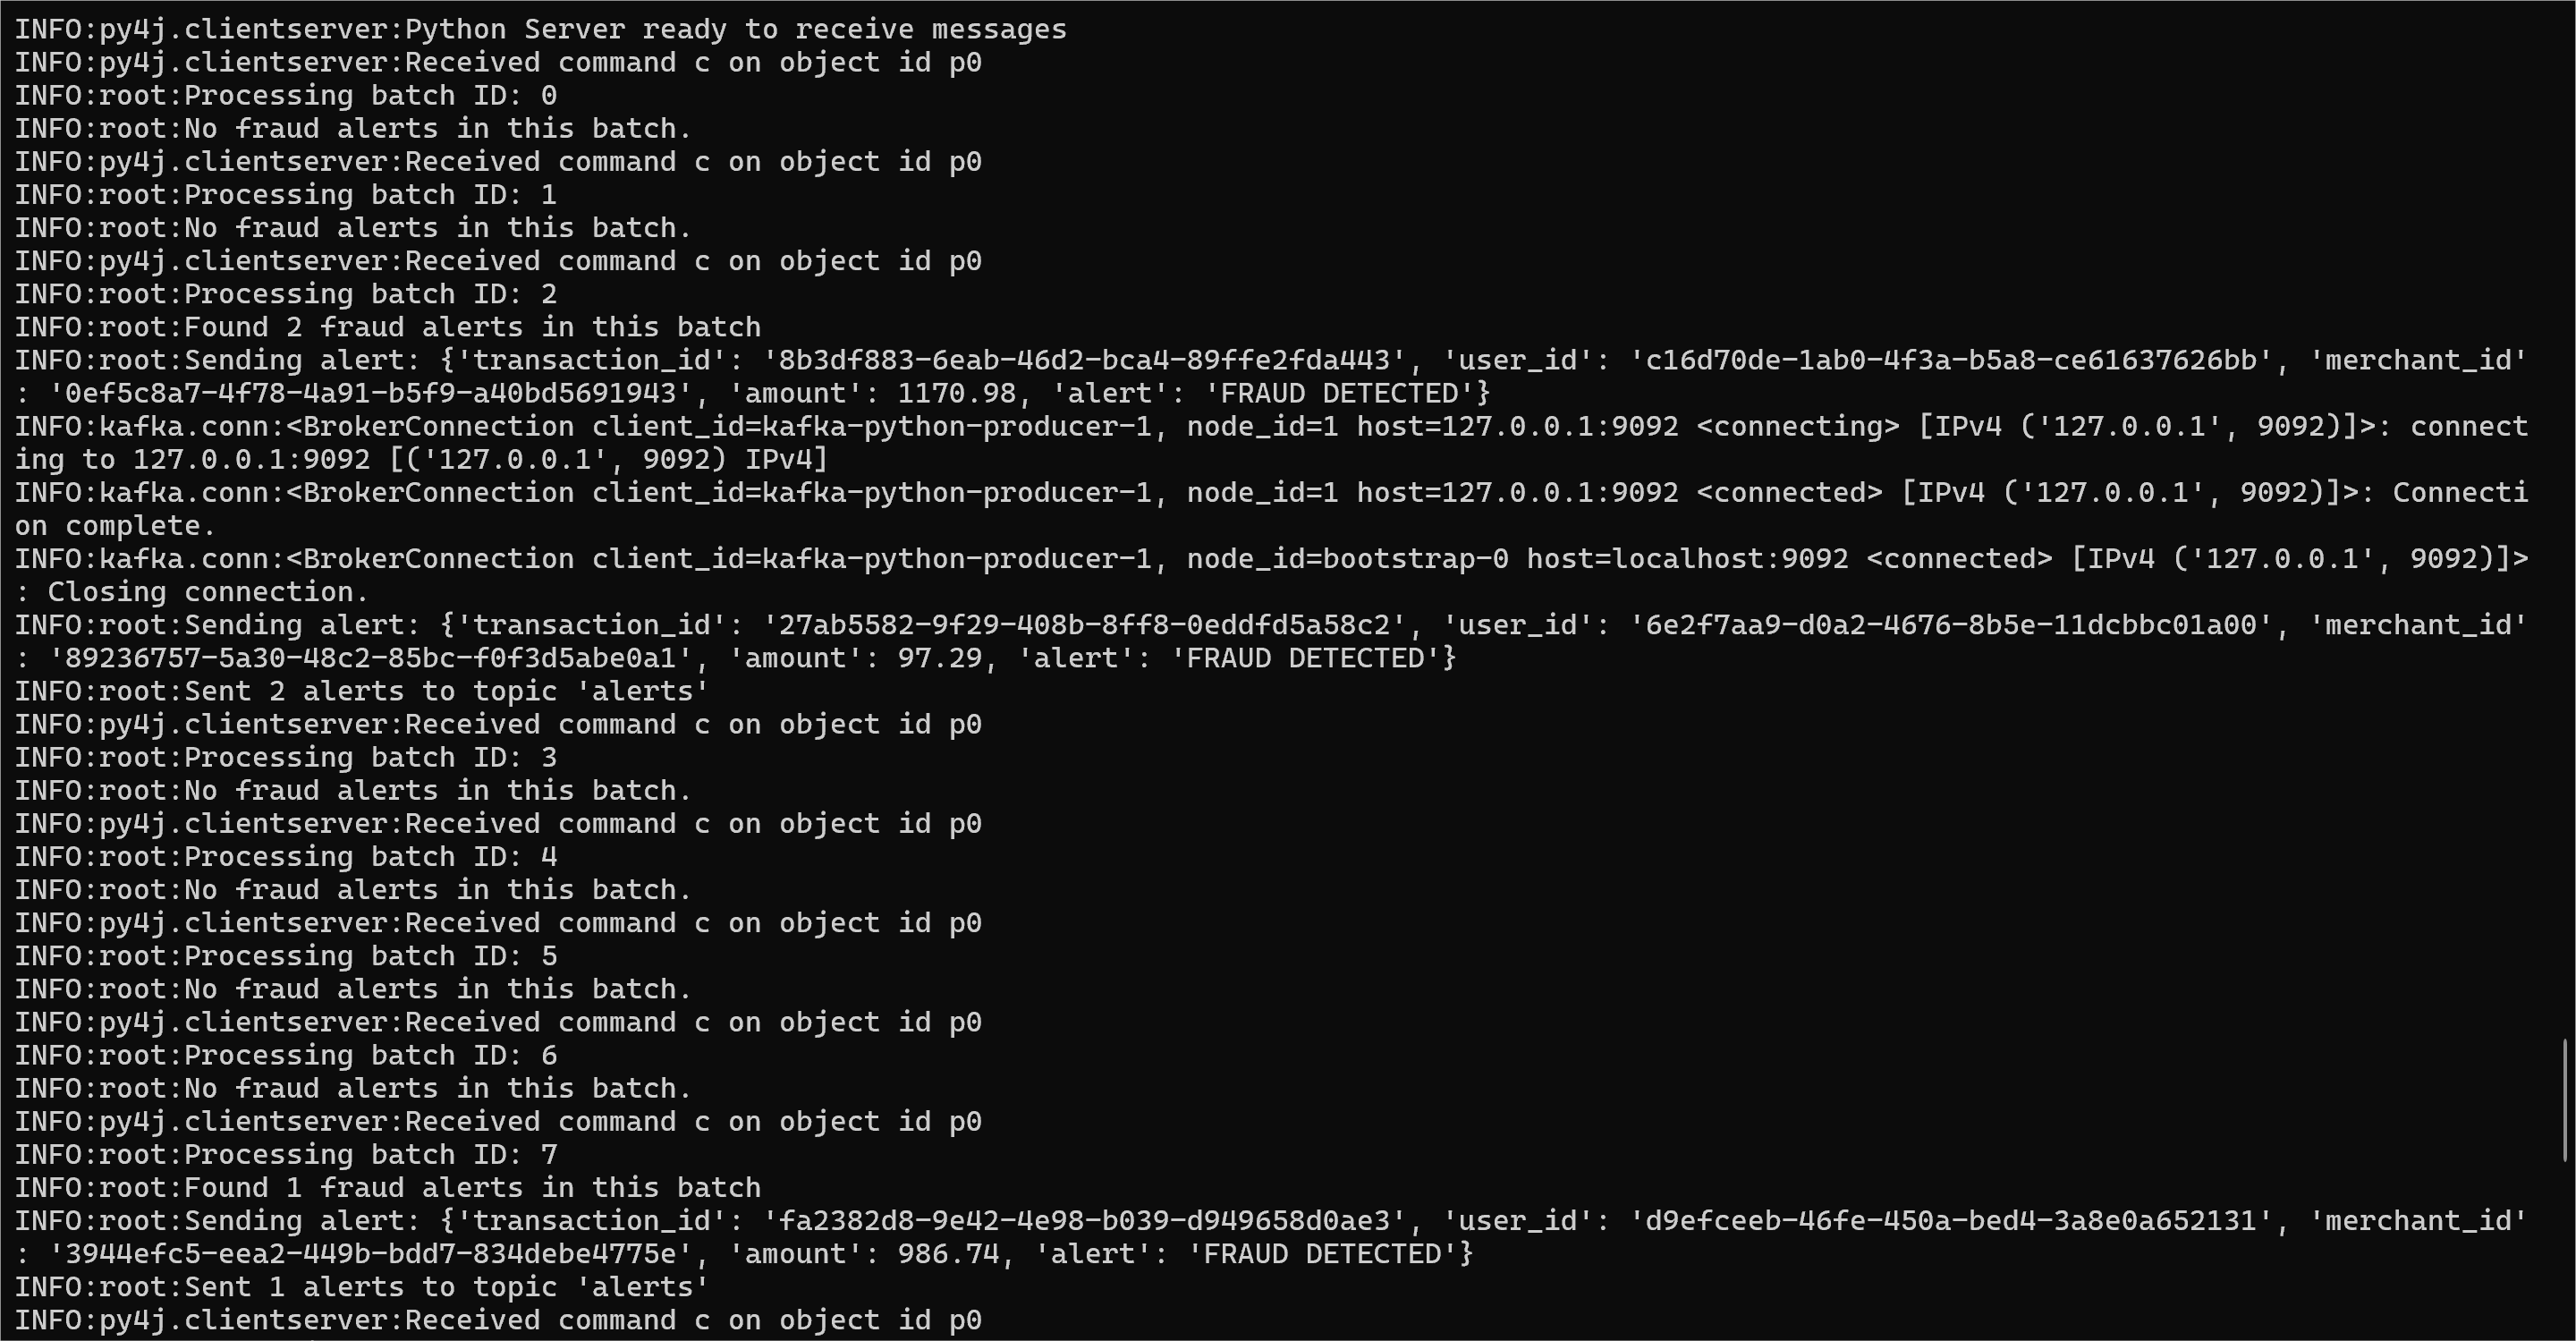

##Terminal 5 – Consume Fraud Alerts and Send Email (SendGrid)

File: **fraud_alert_consumer.py**

Send email to a fixed email

In [ ]:
source ~/venvs/fraud-env/bin/activate

# Run the alert email consumer
cd "/mnt/d/PATH_TO_PROJECT_DIRECTORY"
python src/fraud_alert_consumer.py

> In this project, I am sending emails to a fixed email address. In a real-world situation, we could develop a system to send emails to specific customers based on the **user_info_stream**.

If successful:

- Console will show received fraud alert messages

- Email will be sent using SendGrid (e.g., "Fraud Detected!" notification)

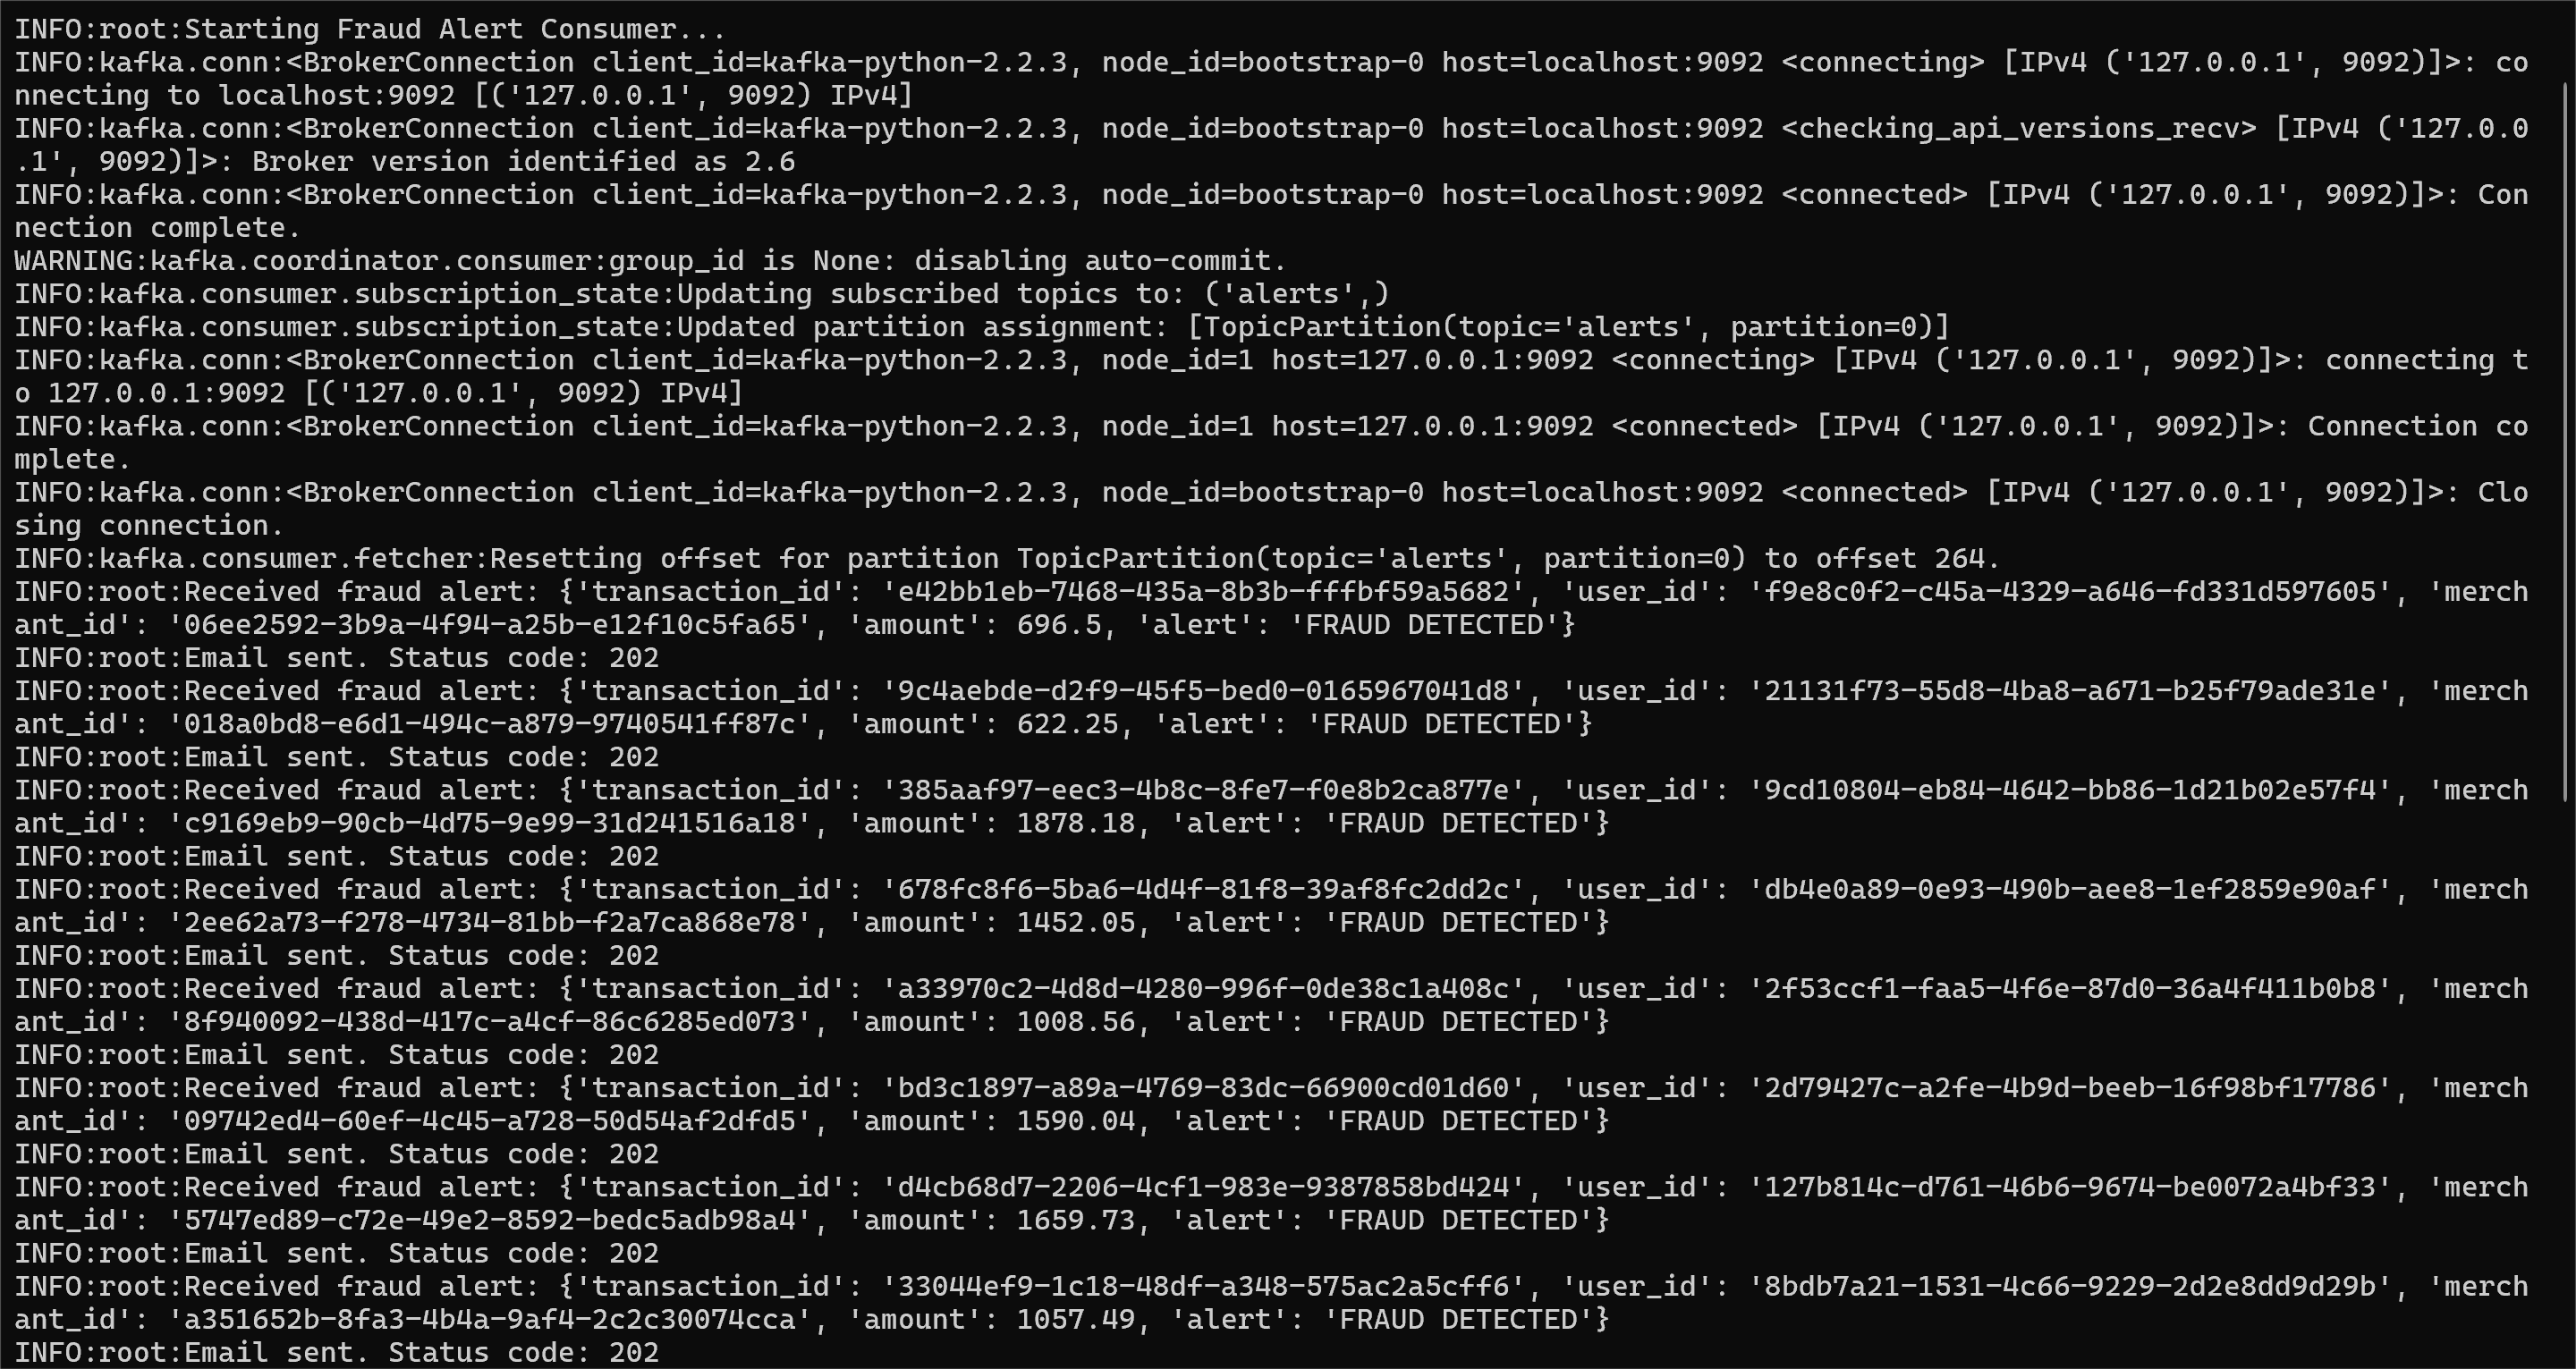

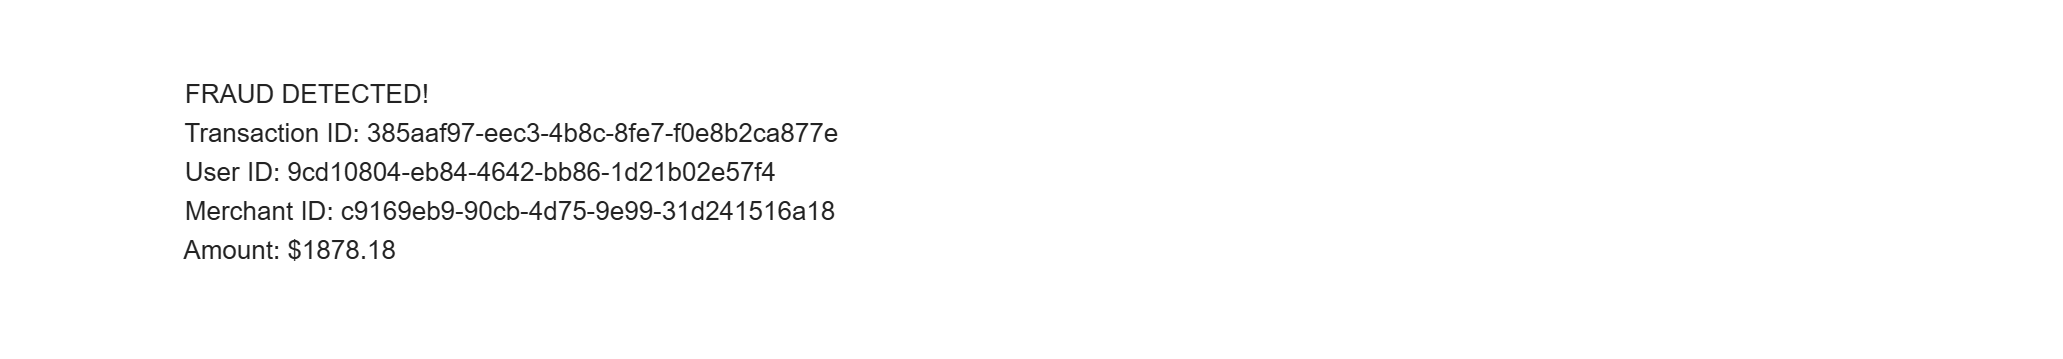

# 3. Orchestration with Airflow

File: **training_pipeline.py**

We'll use Airflow standalone mode for development and learning purposes.

##Terminal 1: Start Airflow Standalone

In [ ]:
# Activate your Python virtual environment
source ~/venvs/fraud-env/bin/activate

# Install pip (if not already installed)
curl -O https://bootstrap.pypa.io/get-pip.py
python get-pip.py --break-system-packages

# Install dependencies
pip install alembic==1.13.1
pip install "apache-airflow==3.0.0" --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-3.0.0/constraints-3.10.txt"

# Set environment variables
export AIRFLOW_HOME=~/PATH_TO_airflow_home
export SPARK_LOCAL_IP=127.0.0.1

# Start Airflow in standalone mode
airflow standalone

> Press Ctrl+C in this terminal to stop the Airflow webserver and scheduler.

##Terminal 2: Deploy and Trigger the DAG

In [ ]:
# Activate the virtual environment
source ~/venvs/fraud-env/bin/activate

# Set the same environment variables
export AIRFLOW_HOME=~/PATH_TO_airflow_home
export SPARK_LOCAL_IP=127.0.0.1

# Copy the DAG file to the Airflow DAGs directory
cp "/mnt/d/PATH_TO/dags/training_pipeline.py" ~/PATH_TO_airflow_home/dags/

In [ ]:
# Trigger the DAG
airflow dags trigger fraud_model_training_pipeline

# Unpause the DAG (if it's paused)
airflow dags unpause fraud_model_training_pipeline

The WSL terminal output:

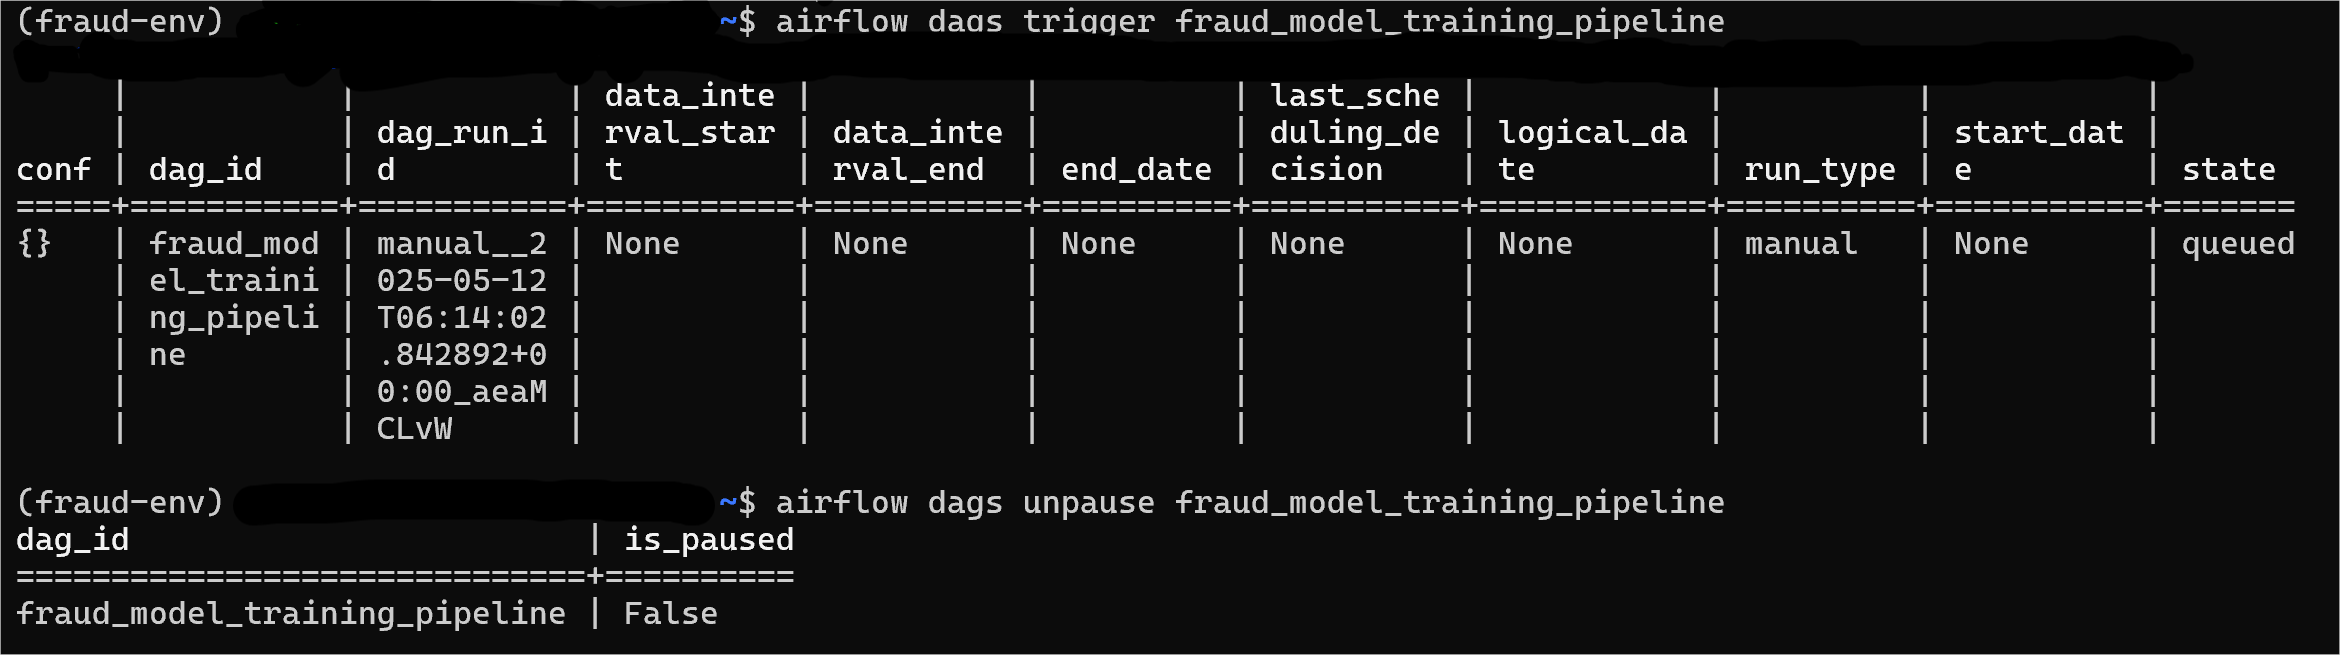

DAG Visualization:

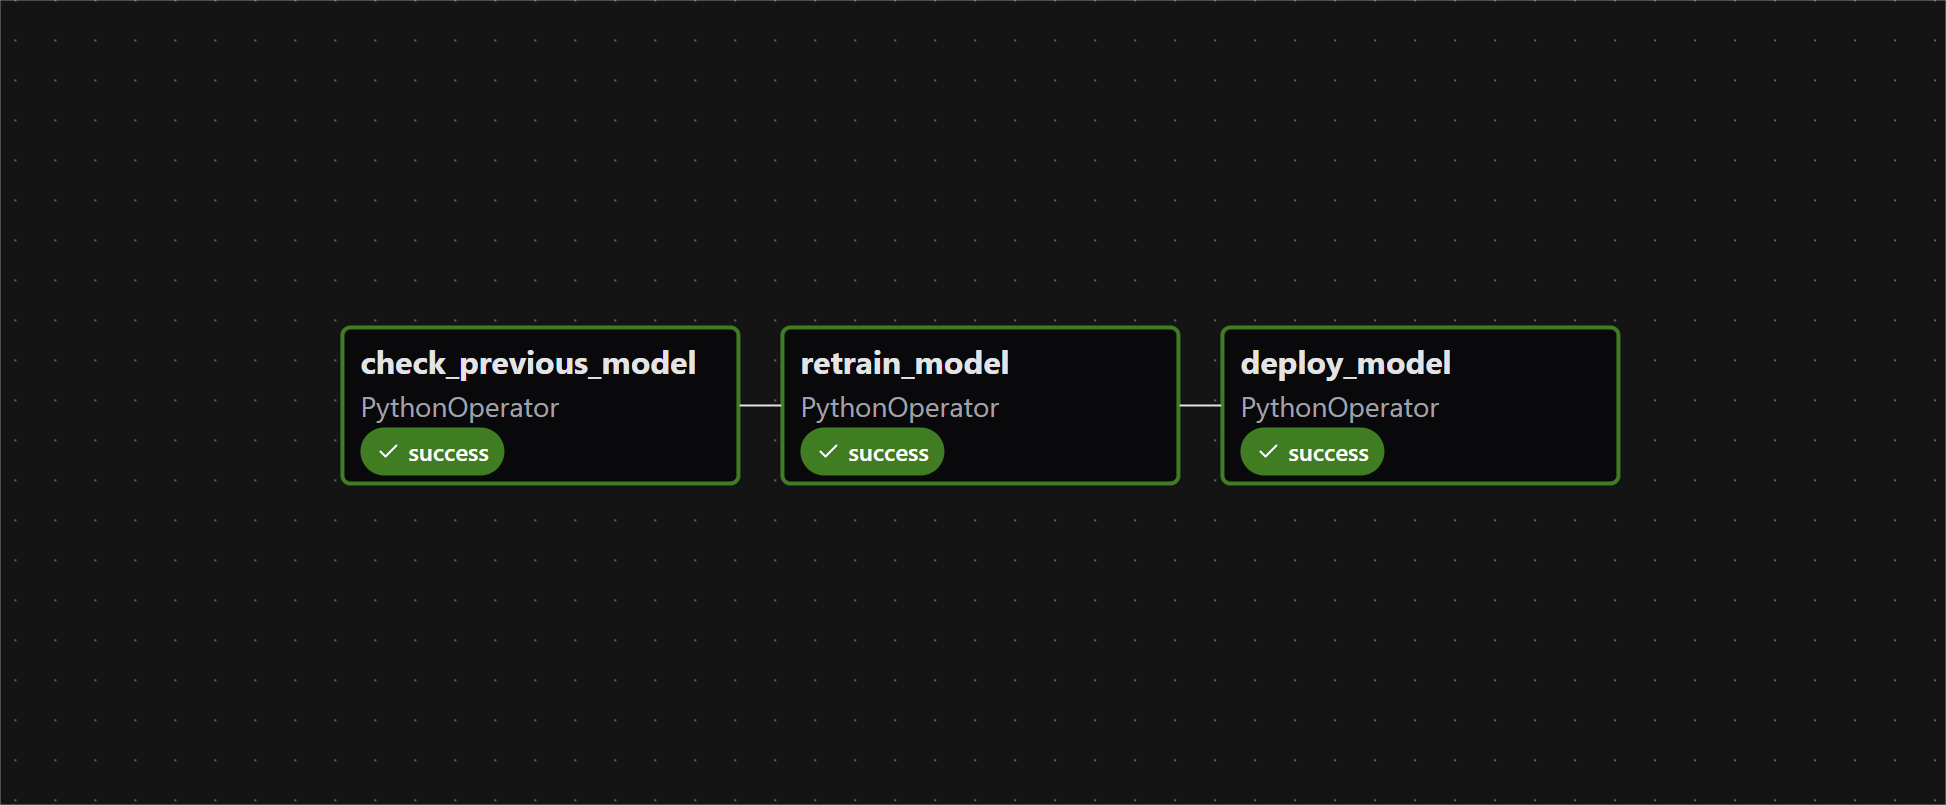





--------------------------------------------------------------------------------